In [1]:
import json
import os
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import training_scripts.domain.sampler as sampler

In [2]:
def load_data(directory):
    data_dicts = []
    for file in os.listdir(directory):
        with open(os.path.join(directory, file), 'r') as f:
            data_dict = json.load(f)
        data_dicts.append(data_dict)
    return data_dicts

In [3]:
def build_dataframe(data_dicts):
    return pd.json_normalize(data_dicts)


def reformat_dataframe(df, columns_to_keep):
    df = df.rename(columns_to_keep, axis=1)
    df = df[list(columns_to_keep.values())]
    return df

In [4]:
def drop_unlabeled_data(df, column):
    return df.dropna(subset=[column])


def balance_data(df, column):
    df_grouped = df.groupby(column)
    sample_size = df_grouped.size().min()

    def sample(df):
        return df.sample(sample_size).reset_index(drop=True)

    df_grouped_sampled = df_grouped.apply(sample)
    df_sampled = pd.DataFrame(df_grouped_sampled)
    df_sampled = df_sampled.droplevel(level=0)
    return df_sampled

In [5]:
def count_keywords(df, columns, keywords):
    for keyword in keywords:

        def count_keyword(string):
            return sum(
                keyword in word
                for word in string.lower().split())

        df[keyword] = df[columns].applymap(count_keyword).sum(axis=1)
    return df

In [6]:
def fit_model(x, y):
    model = LogisticRegression()
    model.fit(x, y)
    return model

In [7]:
def plot_confusion_matrix(model, x, y):
    matrix = confusion_matrix(y, model.predict(x), normalize='true')
    display = ConfusionMatrixDisplay(matrix, ['Not COVID', 'COVID'])
    display.plot()

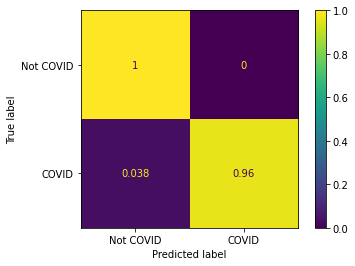

In [8]:
directory = '../data/news_articles/balanced_dataset/'
data = load_data(directory)

df = build_dataframe(data)

columns_to_keep = {
    'LABEL.WANT_ON_MAP': 'label',
    'ARTICLE.TEXT': 'text',
    'ARTICLE.TITLE': 'title'}
df = reformat_dataframe(df, columns_to_keep)

column = 'label'
df = drop_unlabeled_data(df, column)
df = balance_data(df, column)

columns = [
    'text',
    'title']
keywords = [
    'covid',
    'corona',
    'pandem',
    'epidem',
    'mask',
    'quarant']
df = count_keywords(df, columns, keywords)

model = fit_model(df[keywords], df[column].astype(bool))

plot_confusion_matrix(model, df[keywords], df[column].astype(bool))